## Imports

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from datetime import date
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
pd.set_option('display.max_rows', 100)
from stargazer.stargazer import Stargazer


## Raw data loading
Loads the kraken tick by tick dataset and converts the index of the dataframe to a datetime index, which is necessary to generate indicators

In [4]:

kraken_df = pd.read_csv("data/krakenEUR.csv", header = None)
kraken_df.index = pd.to_datetime(kraken_df[0], unit="s")
kraken_df

gold_df = pd.read_csv("data/other_features/gold.csv", sep=",")
gold_df.index = pd.to_datetime(gold_df["Date"], format="%Y%m%d %H%M%S")
gold_df = gold_df.iloc[:, 4:]
gold_df.columns = ["gold_close", 'gold_volume']
gold_df

,gold_close,gold_volume
Date,,
2018-05-01 00:00:00,1315.001,0.29202
2018-05-01 00:15:00,1314.811,0.14218
2018-05-01 00:30:00,1314.801,0.11820
2018-05-01 00:45:00,1315.018,0.14881
2018-05-01 01:00:00,1314.212,0.17924
...,...,...
2021-06-01 22:45:00,1899.158,0.13526
2021-06-01 23:00:00,1899.488,0.15257
2021-06-01 23:15:00,1898.978,0.11692


## Dataset construction functions
Constructing OHLCV and technical indicators in dataframe

In [5]:
#requires tick df with dateTime index, prices in column named 1, volume in column named 2
def construct_ohlcv(df, freq):
    freqStr = str(freq) + "Min"
    resDf = df.resample(freqStr).agg({1: 'ohlc', 2: 'sum'})
    resDf.columns = resDf.columns.to_flat_index()
    resDf.fillna(method="ffill")
    resDf.columns = ["open", "high", "low", "close", "volume"]
    resDf.index.name = "date"
    return resDf

#add RSI, stochastic oscillator Williams%R, macd, OBV
#requires ohlcv dataframe with datetime index.
def add_TI_p1(df_input):
    df = df_input.copy()
    df.ta.rsi(append = True)
    df.ta.stoch(append = True)
    df.ta.willr(append = True)
    df.ta.macd(append = True)
    df.ta.obv(append = True)
    df.ta.sma(append=True)
    df.ta.sma(append=True)
    df.ta.sma(append=True)
    return df

# Adds a single lag of specified column to specified dataframe
def addColShifted(df, period, colname):
    assert isinstance(period, int), "Period in column shifter function is not integer!"
    newName = colname + '_L' + str(period)
    df[newName] = df[colname].shift(periods=period)
    
# Function to add lagged values of column or multiple columns, accepts either a list or a dictionary of column names 
# and lagged values such as: {col1:2, col2:5, ...} or "column_name", requires addColShifted
def addLagsMultiple(df, colnames, periods = 0, rm_na = False):
    max_p = 0
    if isinstance(colnames, dict):
        for key in colnames:
            if (colnames[key] > max_p):
                max_p = colnames[key]
            for i in range(1, colnames[key] + 1):
                addColShifted(df, i, key)
    else:
        assert periods > 0, "colnames is no dictionary, period can't be 0 or negative"
        max_p = periods
        for name in colnames:
            for i in range(1, periods + 1):
                addColShifted(df, i, name)
    if rm_na:
        df = df.iloc[max_p:]
    return(df)     

## Dataset construction
Technical indicators, features and lags

In [6]:
kraken_15 = construct_ohlcv(kraken_df, 15)
kraken_15 = kraken_15.fillna(method="ffill")

dat_15 = add_TI_p1(kraken_15)
dat_15 = dat_15.fillna(method="ffill")

dat_15["diff_no_leak"] = dat_15["close"].diff()
dat_15_lags = dat_15.copy()

# test_df = dat_15.copy()
dat_15 = dat_15.merge(gold_df, how="left", left_index=True, right_index=True)
dat_15 = dat_15.fillna(value = 0)
addLagsMultiple(dat_15_lags, ["close","volume","diff_no_leak"], 14, rm_na = True)
dat_15[dat_15.index > datetime(2019,1,1)]

,open,high,low,close,volume,RSI_14,STOCHk_14_3_3,STOCHd_14_3_3,WILLR_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,OBV,SMA_10,diff_no_leak,gold_close,gold_volume
date,,,,,,,,,,,,,,,,,
2019-01-01 00:15:00,3236.2,3237.1,3228.6,3231.8,8.578142,40.050417,82.765738,83.957703,-26.934985,-11.619174,4.164339,-15.783514,96151.967338,3230.34,-5.3,0.000,0.00000
2019-01-01 00:30:00,3232.0,3243.1,3232.0,3241.4,20.204627,47.092118,85.889213,84.598090,-4.871060,-10.132953,4.520449,-14.653402,96172.171965,3233.62,9.6,0.000,0.00000
2019-01-01 00:45:00,3241.0,3250.0,3237.3,3239.7,27.394098,46.060352,81.184269,83.279740,-24.641148,-8.988672,4.531784,-13.520456,96144.777867,3235.69,-1.7,0.000,0.00000
2019-01-01 01:00:00,3239.5,3241.4,3230.5,3237.7,22.552554,44.816311,80.353985,82.475822,-29.425837,-8.149265,4.296953,-12.446218,96122.225314,3236.58,-2.0,0.000,0.00000
2019-01-01 01:15:00,3237.6,3237.6,3230.0,3236.4,16.257986,43.984725,71.132376,77.556877,-32.535885,-7.502444,3.955019,-11.457463,96105.967328,3237.03,-1.3,0.000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-18 09:45:00,36886.9,37000.4,36785.0,36853.4,54.184333,46.468489,21.807809,14.506981,-73.807768,-13.826204,-61.880000,48.053796,114297.940413,36967.38,-33.2,1867.718,0.44140
2021-05-18 10:00:00,36853.4,36937.7,36732.9,36848.6,46.526827,46.335893,27.139537,20.952946,-67.670340,-21.868533,-55.937864,34.069331,114251.413586,36952.21,-4.8,1868.025,0.41971
2021-05-18 10:15:00,36848.5,37155.1,36810.3,37042.9,103.951085,52.272716,40.336104,29.761150,-37.513581,-12.420574,-37.191924,24.771350,114355.364672,36946.91,194.3,1868.648,0.40154


### Target construction
Calculation of both binary as threshhold (three-class) targets

In [8]:
# Construct the target variable for 3 class (buy, sell or hold) classification
def construct_3_tg(src_df, change, threshold):
    res_name = "y_3_" + str(threshold)
    resdf = pd.DataFrame(0, index=src_df.index, columns=[res_name])
    resdf[res_name][change > threshold] = 1
    resdf[res_name][change < -threshold] = -1
    return resdf[res_name]

# Construct the target variable for 2 class (buy, hold) classification (no short selling)
def construct_2_tg(src_df, change, threshold):
    res_name = "y_2"
    resdf = pd.DataFrame(0, index=src_df.index, columns=[res_name])
    resdf[res_name][change > threshold] = 1
    return resdf[res_name]


res_df = dat_15[["close"]].diff().shift(-1)
res_df.isna()
res_df.columns = ["diff"]
res_df["change"] = res_df["diff"] / dat_15["close"] * 100
res_df['y_3_c'] = construct_3_tg(dat_15, res_df["change"], 0.2)

for threshold in [0, 0.1, 0.2, 0.5]:
    res_df['y_2_' + str(threshold)] = construct_2_tg(dat_15, res_df["change"], threshold)

# res_df['y_2'] = construct_2_tg(dat_15, res_df["change"], 0)
# res_df['y_2_0.1'] = construct_2_tg(dat_15, res_df["change"], 0.1)
# res_df['y_2_0.2'] = construct_2_tg(dat_15, res_df["change"], 0.2)
# res_df['y_2_0.5'] = construct_2_tg(dat_15, res_df["change"], 0.5)
res_df['y_close'] = dat_15['close'].shift(-1)

,diff,change,y_3_c,y_2_0,y_2_0.1,y_2_0.2,y_2_0.5,y_close
date,,,,,,,,
2014-01-08 09:15:00,6.45934,1.035913,1,1,1,1,1,630.00000
2014-01-08 09:30:00,-6.46164,-1.025657,-1,0,0,0,0,623.53836
2014-01-08 09:45:00,0.01164,0.001867,0,1,0,0,0,623.55000
2014-01-08 10:00:00,11.24830,1.803913,1,1,1,1,1,634.79830
2014-01-08 10:15:00,-0.04830,-0.007609,0,0,0,0,0,634.75000
...,...,...,...,...,...,...,...,...
2021-05-18 09:45:00,-4.80000,-0.013025,0,0,0,0,0,36848.60000
2021-05-18 10:00:00,194.30000,0.527293,1,1,1,1,1,37042.90000
2021-05-18 10:15:00,164.50000,0.444080,1,1,1,1,0,37207.40000


## Train and Test sets

In [9]:
#After construction of all features we take the desired subset.
X_train = dat_15[(dat_15.index >= datetime(2018,1,1)) & (dat_15.index < datetime(2019,6,1))]
X_train_val = dat_15[(dat_15.index >= datetime(2019,1,1)) & (dat_15.index < datetime(2020,1,1))]

X_test_lag = dat_15_lags[(dat_15_lags.index >= datetime(2020,1,1)) & (dat_15_lags.index < datetime(2021,1,1))]
X_test = dat_15[(dat_15.index >= datetime(2020,1,1)) & (dat_15.index < datetime(2021,1,1))]

y_train = res_df[(res_df.index >= datetime(2018,1,1)) & (res_df.index < datetime(2019,6,1))]
y_val = res_df[(res_df.index >= datetime(2019,1,1)) & (res_df.index < datetime(2020,1,1))]
y_test = res_df[(res_df.index >= datetime(2020,1,1)) & (res_df.index < datetime(2021,1,1))]

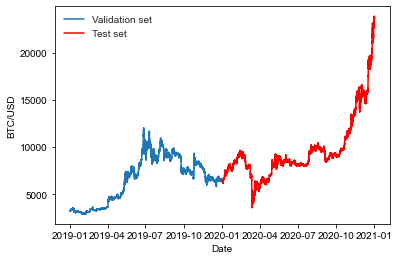

In [10]:
fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')
plt.setp(ax.get_xticklabels(), rotation=0)
plt.xlabel("Date")
plt.ylabel("BTC/USD")

ax.plot(X_train_val.index, X_train_val["close"], label = "Validation set")
ax.plot(X_test.index, X_test["close"], 'r', label="Test set")

ax.legend()
plt.savefig('img/valtestset.eps')

## Modelling
Importing and fitting random forest model using rolling window

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
import statistics

In [12]:
# Function that shifts rolling windows over dataset, trains and tests a random forect model to construct trading signals.
def forecast_rf_binary(X, y, trainDays, testDays, trees):
    assert isinstance(X.index[0], date), "Input dataset is not a timeseries."
    assert len(X) == len(y), "X and y dimensions do not agree."
    
    # Initialize the rolling windows
    startTrainDay = X.index[0]
    endTrainDay = startTrainDay + timedelta(days=trainDays)
    endTestDay = endTrainDay + timedelta(days=testDays)
    lastDate =  X.iloc[-1].name
    assert lastDate > endTestDay, "first testDay is already out of bounds"

    # Initialize the forecasted values
    y_fc = ["NaN"] * len(X[X.index < endTrainDay])
    y_proba = ["NaN"] * len(X[X.index < endTrainDay])
    
    
    while (endTrainDay < lastDate + timedelta(days=1)):
        
        # Current rolling window train and test sets
        maskTrain = (X.index >= pd.to_datetime(startTrainDay)) & (X.index < pd.to_datetime(endTrainDay))
        maskTest = (X.index >= pd.to_datetime(endTrainDay)) & (X.index < pd.to_datetime(endTestDay))
        Xtrain = X[maskTrain]
        Xtest = X[maskTest]
        ytrain = y[maskTrain]
        ytest = y[maskTest]
        
        # Construct trading decisions using random forest
        y_b_fc, y_p_fc = fc_rf_grid_search(Xtrain, ytrain, Xtest, ytest, trees)
        y_fc += y_b_fc
        y_proba += y_p_fc

        # Update rolling window
        startTrainDay = startTrainDay + timedelta(days=testDays)
        endTrainDay = endTrainDay + timedelta(days=testDays)
        endTestDay = endTestDay + timedelta(days=testDays)
    
    return y_fc, y_proba

# Function that can perform a grid search over the number of trees and predict on the test set using the best parameters.
def fc_rf_grid_search(Xtrain, Ytrain, Xtest, Ytest, trees, do_grid_search = False):
    
    # Initialize the random forest model
    rf = RandomForestClassifier(random_state = 280183, n_jobs=-1)
    params_rf = {'n_estimators':trees}
    
    # Perform grid search over the number of trees if required
    if do_grid_search:
        param_grid = {'n_estimators': np.arange(50, 500, 50)}
        grid = GridSearchCV(rf, params_rf, return_train_score=True, cv=TimeSeriesSplit(n_splits=5), n_jobs=-1)
        grid.fit(Xtrain, Ytrain)
        rf.set_params(**grid.best_params_)
    else:
        rf.set_params(**params_rf)

    # Fit the model and predict on the test set
    rf.fit(Xtrain, Ytrain)
    print(rf.score(Xtest, Ytest))
    y_fc = rf.predict(Xtest).tolist()
    y_p_fc = rf.predict_proba(Xtest).tolist()
    return y_fc, y_p_fc

In [13]:
pred_fw_len = 10

# Construct trading decisions using random forest on the validation / training set
rf_val_180_0b, rf_val_180_0p = forecast_rf_binary(X_train_val, y_val.iloc[:,3], 180, pred_fw_len, 100)
rf_val_180_01b, rf_val_180_01p = forecast_rf_binary(X_train_val, y_val.iloc[:,4], 180, pred_fw_len, 100)
rf_val_180_02b, rf_val_180_02p = forecast_rf_binary(X_train_val, y_val.iloc[:,5], 180, pred_fw_len, 100)

# Construct trading decisions using random forest on the test set using the parameters found on the validation set
rf_180_0b, rf_180_0p = forecast_rf_binary(X_test, y_test.iloc[:,3], 180, pred_fw_len, 100)
rf_180_01b, rf_180_01p = forecast_rf_binary(X_test, y_test.iloc[:,4], 180, pred_fw_len, 100)
rf_180_02b, rf_180_02p = forecast_rf_binary(X_test, y_test.iloc[:,5], 180, pred_fw_len, 100)




0.5260416666666666
0.5010416666666667
0.5375
0.5291666666666667
0.53125
0.515625
0.5229166666666667
0.5541666666666667
0.5041666666666667
0.49583333333333335
0.509375
0.5072916666666667
0.540625
0.5083333333333333
0.5104166666666666
0.5229166666666667
0.5104166666666666
0.5364583333333334
0.5125
0.5302083333333333
0.5395833333333333
0.5947916666666667
0.621875
0.6427083333333333
0.6239583333333333
0.703125
0.7479166666666667
0.6875
0.6020833333333333
0.7385416666666667
0.6552083333333333
0.7010416666666667
0.7604166666666666
0.615625
0.6510416666666666
0.6916666666666667
0.7
0.78125
0.5447916666666667
0.6197916666666666
0.7447916666666666
0.75625
0.7927083333333333
0.8010416666666667
0.8447916666666667
0.9
0.828125
0.7979166666666667
0.890625
0.809375
0.85
0.9125
0.7583333333333333
0.796875
0.9166666666666666
0.8458333333333333
0.925
0.5385416666666667
0.5447916666666667
0.471875
0.5104166666666666
0.5208333333333334
0.521875
0.5395833333333333
0.5260416666666666
0.5072916666666667
0.5

In [164]:
# Comparisons between different values for the number of trees

rf_val_t50, _ = forecast_rf_binary(X_train_val, y_val.iloc[:,3], 180, pred_fw_len, 50)
rf_val_t100, _ = forecast_rf_binary(X_train_val, y_val.iloc[:,3], 180, pred_fw_len, 100)
rf_val_t200, _ = forecast_rf_binary(X_train_val, y_val.iloc[:,3], 180, pred_fw_len, 200)
rf_val_t500, _ = forecast_rf_binary(X_train_val, y_val.iloc[:,3], 180, pred_fw_len, 500)
rf_val_t1000, _ = forecast_rf_binary(X_train_val, y_val.iloc[:,3], 180, pred_fw_len, 1000)

names = ["50 trees", "100 trees", "200 trees", "500 trees", "1000 trees"]
print(create_profit_table(y_val["change"][17280:], [rf_val_t50[17280:], rf_val_t100[17280:], rf_val_t200[17280:], rf_val_t500[17280:], rf_val_t1000[17280:]], names).round(2).to_latex(index = False, escape = False))
print(create_class_report([y_val["y_2"][17280:]]*5, [rf_val_t50[17280:], rf_val_t100[17280:], rf_val_t200[17280:], rf_val_t500[17280:], rf_val_t1000[17280:]], names).round(2).to_latex(index = False, escape = False))


\begin{tabular}{lrrr}
\toprule
     Method &    tc=0 &  tc=0.01\% &  tc=0.05\% \\
\midrule
   50 trees &  101.43 &      40.61 &       1.04 \\
  100 trees &  107.67 &      41.26 &       0.89 \\
  200 trees &  109.54 &      40.76 &       0.78 \\
  500 trees &   94.30 &      34.12 &       0.58 \\
 1000 trees &  116.43 &      41.78 &       0.69 \\
\bottomrule
\end{tabular}

\begin{tabular}{llrrrll}
\toprule
     Method & class &  precision &  recall &  f1-score & observation count & accuracy \\
\midrule
   50 trees &     0 &       0.53 &    0.50 &      0.51 &              9023 &    0.518 \\
            &     1 &       0.51 &    0.53 &      0.52 &              8737 &          \\
  100 trees &     0 &       0.53 &    0.48 &      0.50 &              9023 &     0.52 \\
            &     1 &       0.51 &    0.56 &      0.53 &              8737 &          \\
  200 trees &     0 &       0.53 &    0.47 &      0.50 &              9023 &    0.522 \\
            &     1 &       0.51 &    0.58 &      

## LSTM

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

## LSTM for classification

In [46]:
def forecast_LSTM(X, y, trainDays, testDays, time_step = 5, hunits = 36, epochs = 100):
    print("starting now")
    iter = 0
    startTrainDay = X.index[0]
    endTrainDay = startTrainDay + timedelta(days=trainDays)
    lastDate =  X.iloc[-1].name
    y_fc_final_b = []
    y_fc_final_raw = []
    # assert lastDate > endTestDay, "first testDay is already out of bounds"    
    
    while (endTrainDay < lastDate):
        # Data frames for training and testing sets.
        maskTrain = (X.index >= pd.to_datetime(startTrainDay)) & (X.index < pd.to_datetime(endTrainDay))
        Xtrain = X[maskTrain]
        if (iter == 0):
            y_fc_final_b += ["NaN"] * len(Xtrain)
            y_fc_final_raw += [-1] * len(Xtrain)

        # 15 minute data so 24 * 4 observations per day
        Xtest = X.iloc[len(Xtrain)+iter*24*4*testDays-time_step+1:len(Xtrain)+24*4*testDays*(1+iter)]
        ytrain = y[maskTrain]
        ytrain = ytrain.iloc[time_step-1:,]
        ytest = y.iloc[len(Xtrain)+iter*24*4*testDays:len(Xtrain)+24*4*testDays*(1+iter)]

        stc = StandardScaler()
        training_set_scaled = stc.fit_transform(Xtrain.values)
        test_set_scaled = stc.transform(Xtest.values)

        X_train_3d = []
        for i in range(time_step, len(Xtrain)+1):
            X_train_3d.append(training_set_scaled[i-time_step:i, :])
        X_train_3d = np.array(X_train_3d)

        X_test_3d = []
        for i in range(time_step, len(Xtest)+1):
            X_test_3d.append(test_set_scaled[i-time_step:i, :])
        X_test_3d = np.array(X_test_3d)

        y_fc_binary, y_fc_raw = apply_lstm(X_train_3d, ytrain, X_test_3d, ytest, hunits, epochs)
        y_fc_final_b += y_fc_binary 
        y_fc_final_raw += y_fc_raw
        iter+=1    
        startTrainDay = startTrainDay + timedelta(days=testDays)
        print(f"Training currently starting at: {startTrainDay}")
        endTrainDay = endTrainDay + timedelta(days=testDays)
        # print(f"start train: {Xtrain.index[0]}, start end: {Xtrain.index[-1]}, test_init: {Xtest.index[0]}, test_start:{ytest.index[0]}, test_end:{ytest.index[-1]}")
        # print(f"train_shape: {Xtrain.shape}, train_shape_3d: {X_train_3d.shape}, test_shape: {Xtest.shape}, X_test_3d_shape:{X_test_3d.shape}")
    # print(f"ytest_shape: {ytrain.index}, \n Test: {Xtrain.index}")
    return y_fc_final_b, y_fc_final_raw

def apply_lstm(Xtrain, Ytrain, Xtest, Ytest, hunits, epochs_inp):
    # print(Ytest)
    classifier = Sequential()
    classifier.add(LSTM(units = hunits, return_sequences = True, input_shape = (Xtrain.shape[1], Xtrain.shape[2])))
    classifier.add(Dropout(0.2))
    classifier.add(LSTM(units = hunits))
    classifier.add(Dense(units = 1, activation ='sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    classifier.fit(Xtrain, Ytrain, epochs = epochs_inp, batch_size = 48, verbose = 0)

    predicted_movement = classifier.predict(Xtest)
    # print(f"predicted movement:{predicted_movement[0:30]}")
    
    predicted_movement_binary = []
    for pred in predicted_movement:
        if pred > 0.5:
            predicted_movement_binary.append(1)
        elif pred <= 0.5: 
            predicted_movement_binary.append(0)
    predicted_movement_binary
    predicted_movement = np.array(predicted_movement).flatten().tolist()
    # print(f"predicted movement:{predicted_movement[0:5]}")
    # print(f"predicted movement binary:{predicted_movement_binary}")
    print(classification_report(Ytest,predicted_movement_binary, digits = 4))

    return predicted_movement_binary, predicted_movement

In [34]:
len(rf_180_0b)

35136

## Loop to run all LSTM's on all thresholds.

In [108]:
# Base predictions
y_fc_180_0b, y_fc_180_0p = forecast_LSTM(X_test, y_test.iloc[:,3], 180, 10, time_step = 96, epochs = 10)
np.savetxt("y_lstm_180_0b_test.csv", np.array(y_fc_180_0b), fmt="%10s")
np.savetxt("y_lstm_180_0p_test.csv", np.array(y_fc_180_0p), fmt="%10s")
y_fc_180_01b, y_fc_180_01p = forecast_LSTM(X_test, y_test.iloc[:,4], 180, 10, time_step = 96, epochs = 10)
np.savetxt("y_lstm_180_01b_test.csv", np.array(y_fc_180_01b), fmt="%10s")
np.savetxt("y_lstm_180_01p_test.csv", np.array(y_fc_180_01p), fmt="%10s")
y_fc_180_02b, y_fc_180_02p = forecast_LSTM(X_test, y_test.iloc[:,5], 180, 10, time_step = 96, epochs = 10)
np.savetxt("y_lstm_180_02b_test.csv", np.array(y_fc_180_02b), fmt="%10s")
np.savetxt("y_lstm_180_02p_test.csv", np.array(y_fc_180_02p), fmt="%10s")


2020-04-20 00:00:00
              precision    recall  f1-score   support

           0     0.4749    0.5876    0.5253       451
           1     0.5373    0.4244    0.4742       509

    accuracy                         0.5010       960
   macro avg     0.5061    0.5060    0.4997       960
weighted avg     0.5080    0.5010    0.4982       960

Training currently starting at: 2020-04-30 00:00:00
              precision    recall  f1-score   support

           0     0.5000    0.6521    0.5660       457
           1     0.5632    0.4076    0.4729       503

    accuracy                         0.5240       960
   macro avg     0.5316    0.5298    0.5194       960
weighted avg     0.5331    0.5240    0.5172       960

Training currently starting at: 2020-05-10 00:00:00
              precision    recall  f1-score   support

           0     0.5654    0.3095    0.4000       475
           1     0.5314    0.7670    0.6278       485

    accuracy                         0.5406       960
   m

In [49]:
len(y_fc_180_02b)

35136

In [67]:
# Other moving window lengths
y_fc_90_0b, y_fc_90_0p = forecast_LSTM(X_test[8640:], y_test.iloc[8640:,3], 90, 10, time_step = 96, epochs = 10)
np.savetxt("y_lstm_90_0b_test.csv", np.array(y_fc_90_0b), fmt="%10s")
np.savetxt("y_lstm_90_0p_test.csv", np.array(y_fc_90_0p), fmt="%10s")
y_fc_90_01b, y_fc_90_01p = forecast_LSTM(X_test[8640:], y_test.iloc[8640:,4], 90, 10, time_step = 96, epochs = 10)
np.savetxt("y_lstm_90_01b_test.csv", np.array(y_fc_90_01b), fmt="%10s")
np.savetxt("y_lstm_90_01p_test.csv", np.array(y_fc_90_01p), fmt="%10s")
y_fc_90_02b, y_fc_90_02p = forecast_LSTM(X_test[8640:], y_test.iloc[8640:,5], 90, 10, time_step = 96, epochs = 10)
np.savetxt("y_lstm_90_02b_test.csv", np.array(y_fc_90_02b), fmt="%10s")
np.savetxt("y_lstm_90_02p_test.csv", np.array(y_fc_90_02p), fmt="%10s")

y_fc_30_0b, y_fc_30_0p = forecast_LSTM(X_test[14400:], y_test.iloc[14400:,3], 30, 10, time_step = 96, epochs = 10)
np.savetxt("y_lstm_30_0b_test.csv", np.array(y_fc_30_0b), fmt="%10s")
np.savetxt("y_lstm_30_0p_test.csv", np.array(y_fc_30_0p), fmt="%10s")
y_fc_30_01b, y_fc_30_01p = forecast_LSTM(X_test[14400:], y_test.iloc[14400:,4], 30, 10, time_step = 96, epochs = 10)
np.savetxt("y_lstm_30_01b_test.csv", np.array(y_fc_30_01b), fmt="%10s")
np.savetxt("y_lstm_30_01p_test.csv", np.array(y_fc_30_01p), fmt="%10s")
y_fc_30_02b, y_fc_30_02p = forecast_LSTM(X_test[14400:], y_test.iloc[14400:,5], 30, 10, time_step = 96, epochs = 10)
np.savetxt("y_lstm_30_02b_test.csv", np.array(y_fc_30_02b), fmt="%10s")
np.savetxt("y_lstm_30_02p_test.csv", np.array(y_fc_30_02p), fmt="%10s")


starting now
              precision    recall  f1-score   support

           0     0.5496    0.4381    0.4876       493
           1     0.5115    0.6210    0.5609       467

    accuracy                         0.5271       960
   macro avg     0.5305    0.5296    0.5243       960
weighted avg     0.5311    0.5271    0.5233       960

Training currently starting at: 2020-04-10 00:00:00
              precision    recall  f1-score   support

           0     0.5393    0.6240    0.5785       484
           1     0.5450    0.4580    0.4977       476

    accuracy                         0.5417       960
   macro avg     0.5421    0.5410    0.5381       960
weighted avg     0.5421    0.5417    0.5385       960

Training currently starting at: 2020-04-20 00:00:00
              precision    recall  f1-score   support

           0     0.4868    0.5885    0.5328       469
           1     0.5089    0.4073    0.4525       491

    accuracy                         0.4958       960
   macro av

KeyboardInterrupt: 

In [109]:
# To select weights weighted average ensemble
y_fct_180_0b, y_fct_180_0p = forecast_LSTM(X_train_val, y_val.iloc[:,3], 180, 10, time_step = 96, epochs = 10)
np.savetxt("y_lstm_180_0b_train.csv", np.array(y_fct_180_0b), fmt="%10s")
np.savetxt("y_lstm_180_0p_train.csv", np.array(y_fct_180_0p), fmt="%10s")
y_fct_180_01b, y_fct_180_01p = forecast_LSTM(X_train_val, y_val.iloc[:,4], 180, 10, time_step = 96, epochs = 10)
np.savetxt("y_lstm_180_01b_train.csv", np.array(y_fct_180_01b), fmt="%10s")
np.savetxt("y_lstm_180_01p_train.csv", np.array(y_fct_180_01p), fmt="%10s")
y_fct_180_02b, y_fct_180_02p = forecast_LSTM(X_train_val, y_val.iloc[:,5], 180, 10, time_step = 96, epochs = 10)
np.savetxt("y_lstm_180_02b_train.csv", np.array(y_fct_180_02b), fmt="%10s")
np.savetxt("y_lstm_180_02p_train.csv", np.array(y_fct_180_02p), fmt="%10s")

core   support

           0     0.5419    0.5386    0.5403       492
           1     0.5180    0.5214    0.5197       468

    accuracy                         0.5302       960
   macro avg     0.5300    0.5300    0.5300       960
weighted avg     0.5303    0.5302    0.5302       960

Training currently starting at: 2019-06-10 00:00:00
              precision    recall  f1-score   support

           0     0.5451    0.5532    0.5491       470
           1     0.5652    0.5571    0.5612       490

    accuracy                         0.5552       960
   macro avg     0.5551    0.5552    0.5551       960
weighted avg     0.5554    0.5552    0.5553       960

Training currently starting at: 2019-06-20 00:00:00
              precision    recall  f1-score   support

           0     0.5452    0.4280    0.4795       479
           1     0.5308    0.6445    0.5822       481

    accuracy                         0.5365       960
   macro avg     0.5380    0.5362    0.5308       960
weighted 

# Evaluation

In [21]:
from scipy.stats import kurtosis
from scipy.stats import skew
def ensemble_predict(pred_a, pred_b):
    assert len(pred_a) == len(pred_b), f"length of first prediction vector ({len(pred_a)}) does not match length of second prediction vector ({len(pred_b)})"
    pred_a = list(pred_a)
    pred_b = list(pred_b)
    ensemble = [0] * len(pred_a)
    for i, pred_cur in enumerate(pred_a):
        pred_b_cur = pred_b[i]
        if (pred_cur == pred_b_cur & pred_cur == 1):
            ensemble[i] = 1
        else:
            ensemble[i] = 0
    return ensemble

def extract_prob_pos(rf_proba):
    rf_pos = []
    for item in rf_proba:
        rf_pos += [item[1]]
    return rf_pos

def proba_ens(pred_a, pred_b, weight, theta = 0.5):
    assert len(pred_a) == len(pred_b), f"length of first prediction vector ({len(pred_a)}) does not match length of second prediction vector ({len(pred_b)})"
    if (weight > 1):
        weight = 1
    elif (weight < 0):
        weight = 0
    pred_a = list(pred_a)
    pred_b = list(pred_b)
    ensemble = [0] * len(pred_a)
    for i, pred_cur in enumerate(pred_a):
        pred_b_cur = pred_b[i]
        weighted_cur = pred_cur * weight + pred_b_cur * (1-weight)
        if weighted_cur > theta:
            ensemble[i] = 1
        else: 
            ensemble[i] = 0
    return ensemble

## construct ensembles
and classification reports

In [134]:
lstm_30_0 = pd.read_csv("y_lstm_30_0b_test.csv", header = None)[2880:].iloc[:,0].astype(int)
lstm_90_0 = pd.read_csv("y_lstm_90_0b_test.csv", header = None)[8640:].iloc[:,0].astype(int)
lstm_30_01 = pd.read_csv("y_lstm_30_01b_test.csv", header = None)[2880:].iloc[:,0].astype(int)
lstm_90_01 = pd.read_csv("y_lstm_90_01b_test.csv", header = None)[8640:].iloc[:,0].astype(int)
lstm_30_02 = pd.read_csv("y_lstm_30_02b_test.csv", header = None)[2880:].iloc[:,0].astype(int)
lstm_90_02 = pd.read_csv("y_lstm_90_02b_test.csv", header = None)[8640:].iloc[:,0].astype(int)

lstm_180_0 = pd.read_csv("y_lstm_180_0b_test.csv", header = None)[17280:].iloc[:,0].astype(int)
lstm_180_01 = pd.read_csv("y_lstm_180_01b_test.csv", header = None)[17280:].iloc[:,0].astype(int)
lstm_180_02 = pd.read_csv("y_lstm_180_02b_test.csv", header = None)[17280:].iloc[:,0].astype(int)

lstm_180_0p = pd.read_csv("y_lstm_180_0p_test.csv", header = None)[17280:].iloc[:,0].astype(float)
lstm_180_01p = pd.read_csv("y_lstm_180_01p_test.csv", header = None)[17280:].iloc[:,0].astype(float)
lstm_180_02p = pd.read_csv("y_lstm_180_02p_test.csv", header = None)[17280:].iloc[:,0].astype(float)

rf_30_0 = rf_30_0b[2880:]
rf_30_01 = rf_30_01b[2880:]
rf_30_02 = rf_30_02b[2880:]

rf_90_0 = rf_90_0b[8640:]
rf_90_01 = rf_90_01b[8640:]
rf_90_02 = rf_90_02b[8640:]

rf_180_0 = rf_180_0b[17280:]
rf_180_01 = rf_180_01b[17280:]
rf_180_02 = rf_180_02b[17280:]

# rf_180_0p = rf_180_0p[17280:]
# rfs_180_01p = rf_180_01p[17280:]
# rfs_180_02p = rf_180_02p[17280:]

ens_180_0 = ensemble_predict(lstm_180_0, rf_180_0)
ens_180_01 = ensemble_predict(lstm_180_01, rf_180_01)
ens_180_02 = ensemble_predict(lstm_180_02, rf_180_02)

ens_90_0 = ensemble_predict(lstm_90_0, rf_90_0)
ens_90_01 = ensemble_predict(lstm_90_01, rf_90_01)
ens_90_02 = ensemble_predict(lstm_90_02, rf_90_02)

ens_30_0 = ensemble_predict(lstm_30_0, rf_30_0)
ens_30_01 = ensemble_predict(lstm_30_01, rf_30_01)
ens_30_02 = ensemble_predict(lstm_30_02, rf_30_02)

ens_p058 = proba_ens(lstm_180_02p, rf_180_02p, 0.586)

lstm_val_180_0p = pd.read_csv("y_lstm_180_0p_train.csv", header = None)[17280:].iloc[:,0].astype(float)
lstm_val_180_01p = pd.read_csv("y_lstm_180_01p_train.csv", header = None)[17280:].iloc[:,0].astype(float)
lstm_val_180_02p = pd.read_csv("y_lstm_180_02p_train.csv", header = None)[17280:].iloc[:,0].astype(float)

rf_val_0p = extract_prob_pos(rf_val_180_0p[17280:])
rf_val_01p = extract_prob_pos(rf_val_180_01p[17280:])
rf_val_02p = extract_prob_pos(rf_val_180_02p[17280:])

# Naive forecast and buy & hold
naive_fc_0 = y_test[17279:len(y_test)-1]["y_2"]
naive_fc_01 = y_test[17279:len(y_test)-1]["y_2_0.1"]
naive_fc_02 = y_test[17279:len(y_test)-1]["y_2_0.2"]

bh_fc = [1] * 17856
y_test_sub = y_test[17280:]
true_changes = y_test.iloc[17280:,1]



w_max: 1.0, prof:0.06452113554446852, theta:0.5
w_max: 1.0, prof:62.28924742089363, theta:0.5
w_max: 0.5862068965517241, prof:105.93744484550233, theta:0.5


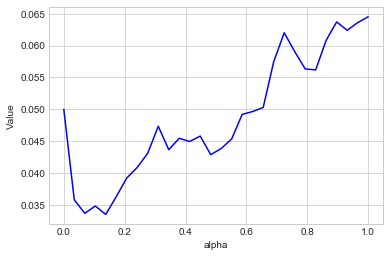

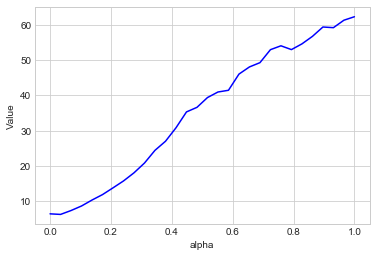

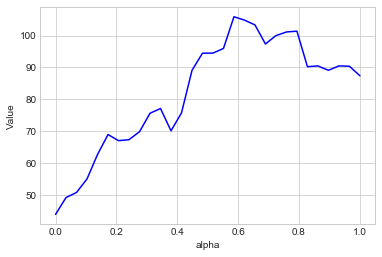

In [194]:
# print(create_profit_table(y_test_sub["change"], [ens_180_0, ens_180_0p, ens_180_0p3, lstm_180_0, rf_180_0, naive_fc_0, bh_fc], ["Ensemble, original", "Ensemble, w = 0.5", "Ensemble, w=0.3", "LSTM, $\theta = 0$", "RF, $\theta = 0$", "Naive forecast", "Buy and hold"]).round(2).to_latex(index = False, escape = False))
def find_weight(lstm, rf, true_changes, pltname = "untitled"):
    max_prof = 0
    w_max = 0
    theta_max = 0
    wvec = np.linspace(0,1,30)
    profit_vec = [0] * 30
    for i, w in enumerate(np.linspace(0,1,30)):
            ens_cur = proba_ens(lstm, rf, w)
            profit_vec[i] = calc_profit(true_changes, ens_cur, 0.0008)
            if profit_vec[i] > max_prof:
                max_prof = profit_vec[i]
                w_max = w
                theta_max = theta
    print(f"w_max: {w_max}, prof:{max_prof}, theta:{theta_max}")
    fig, ax = plt.subplots()
    plt.style.use('seaborn-whitegrid')
    plt.xlabel('alpha')
    plt.ylabel("Value")
    ax.plot(wvec, profit_vec, 'b', label = "Training loss")
    plt.savefig(f'img/{pltname}.eps')  

find_weight(lstm_val_180_0p, rf_val_0p, y_val.iloc[17280:,1], "w0_proba_ens")
find_weight(lstm_val_180_01p, rf_val_01p, y_val.iloc[17280:,1], "w01_proba_ens")
find_weight(lstm_val_180_02p, rf_val_02p, y_val.iloc[17280:,1], "w02_proba_ens")


In [189]:
def create_class_report(true_classes, predictions_list, names_list, digits_cr = 3):
    df = pd.DataFrame(columns=["Method", "class", "precision", "recall", "f1-score", "observation count", "accuracy"])
    for i, predic_vec in enumerate(predictions_list):
        # print(names_list[i])
        cr = classification_report(true_classes[i], predic_vec, digits = digits_cr, output_dict = True)
        for key in ["0", "1"]:
            cr[key]["observation count"] = cr[key].pop("support")
        df = df.append({"Method":names_list[i], "class":0, **cr["0"], "accuracy":np.round(cr["accuracy"], decimals=3)}, ignore_index=True)
        df = df.append({"Method":"", "class":1, **cr["1"], "accuracy":""}, ignore_index=True)
    return df

def trade_counts(predictions_list, names_list):
    thresh_levels = ['0', '0.1', '0.2']
    df = pd.DataFrame(columns=["$\theta$"] + names_list)
    for j, theta in enumerate(thresh_levels):
        z = {"$\theta$":theta}
        for i, predic_vec in enumerate(predictions_list[j]):
            z_cur = {names_list[i]: str(np.round((np.sum(predic_vec) / len(predic_vec))*100, decimals=2)) + "\%"}
            z = {**z, **z_cur}
        df = df.append(z, ignore_index=True)    
    return df

# true_classes_list = [y_test_sub["y_2"]] + [y_test_sub["y_2_0.1"]] + [y_test_sub["y_2_0.2"]] + [y_test_sub["y_2"]] * 3
print(trade_counts([[ens_180_0, lstm_180_0, rf_180_0], [ens_180_01, lstm_180_01, rf_180_01], [ens_180_02, lstm_180_02, rf_180_02]], ["Ensemble", "LSTM", "RF"]).to_latex(index = False, escape = False))
# print(create_class_report(true_classes_list, [ens_180_0,  ens_180_01, ens_180_02, lstm_180_0, rf_180_0, naive_fc_0], ["Ensemble, $\theta = 0$", "Ensemble, $\theta = 0.1$", "Ensemble, $\theta = 0.2$", "LSTM, $\theta = 0$", "RF, $\theta = 0$", "Naive forecast"]).round(2).to_latex(index = False, escape = False))

\begin{tabular}{llll}
\toprule
$\theta$ & Ensemble &     LSTM &       RF \\
\midrule
       0 &  29.56\% &  48.58\% &  44.88\% \\
     0.1 &   2.48\% &   4.31\% &  12.59\% \\
     0.2 &   0.73\% &   1.19\% &   3.87\% \\
\bottomrule
\end{tabular}



In [137]:
print(create_class_report([y_test_sub["y_2"]]*4, [ens_180_0, lstm_180_0, rf_180_0, naive_fc_0], ["Ensemble", "LSTM", "RF", "Naive forecast"]).round(2).to_latex(index = False, escape = False))
print(create_class_report([y_test_sub["y_2_0.1"]]*4, [ens_180_01, lstm_180_01, rf_180_01, naive_fc_01], ["Ensemble", "LSTM", "RF", "Naive forecast"]).round(2).to_latex(index = False, escape = False))
print(create_class_report([y_test_sub["y_2_0.2"]]*5, [ens_180_02, ens_p058, lstm_180_02, rf_180_02, naive_fc_01], ["Ensemble","Weighted Avg Ensemble", "LSTM", "RF", "Naive forecast"]).round(2).to_latex(index = False, escape = False))

\begin{tabular}{llrrrll}
\toprule
         Method & class &  precision &  recall &  f1-score & observation count & accuracy \\
\midrule
       Ensemble &     0 &       0.51 &    0.73 &      0.60 &              8744 &    0.518 \\
                &     1 &       0.55 &    0.32 &      0.40 &              9112 &          \\
           LSTM &     0 &       0.52 &    0.54 &      0.53 &              8744 &    0.529 \\
                &     1 &       0.54 &    0.51 &      0.53 &              9112 &          \\
             RF &     0 &       0.51 &    0.57 &      0.54 &              8744 &    0.518 \\
                &     1 &       0.53 &    0.47 &      0.50 &              9112 &          \\
 Naive forecast &     0 &       0.47 &    0.47 &      0.47 &              8744 &    0.479 \\
                &     1 &       0.49 &    0.49 &      0.49 &              9112 &          \\
\bottomrule
\end{tabular}

\begin{tabular}{llrrrll}
\toprule
         Method & class &  precision &  recall &  f1-score 

In [158]:
# APPENDIX
eval_app = [y_test_sub["y_2"]]*3 + [y_test_sub["y_2_0.1"]] * 3 + [y_test_sub["y_2_0.2"]]*3
pred_app = [lstm_180_0, lstm_90_0, lstm_30_0, lstm_180_01, lstm_90_01, lstm_30_01, lstm_180_02, lstm_90_02, lstm_30_02]
names_app = ["180 days, $\theta = 0$", "90 days, $\theta = 0$", "30 days, $\theta = 0$", "180 days, $\theta = 0.1$", "90 days, $\theta = 0.1$", "30 days, $\theta = 0.1$", "180 days, $\theta = 0.2$", "90 days, $\theta = 0.2$",  "30 days, $\theta = 0.2$",]
print(create_class_report(eval_app, pred_app, names_app).round(2).to_latex(index = False, escape = False))

\begin{tabular}{llrrrll}
\toprule
                   Method & class &  precision &  recall &  f1-score & observation count & accuracy \\
\midrule
   180 days, $\theta = 0$ &     0 &       0.52 &    0.54 &      0.53 &              8744 &    0.529 \\
                          &     1 &       0.54 &    0.51 &      0.53 &              9112 &          \\
    90 days, $\theta = 0$ &     0 &       0.51 &    0.53 &      0.52 &              8744 &    0.522 \\
                          &     1 &       0.53 &    0.52 &      0.53 &              9112 &          \\
    30 days, $\theta = 0$ &     0 &       0.50 &    0.54 &      0.52 &              8744 &    0.514 \\
                          &     1 &       0.53 &    0.49 &      0.50 &              9112 &          \\
 180 days, $\theta = 0.1$ &     0 &       0.72 &    0.97 &      0.82 &             12621 &    0.709 \\
                          &     1 &       0.52 &    0.08 &      0.13 &              5235 &          \\
  90 days, $\theta = 0.1$ &   

In [159]:
# APPENDIX
eval_app = [y_test_sub["y_2"]]*3 + [y_test_sub["y_2_0.1"]] * 3 + [y_test_sub["y_2_0.2"]]*3
pred_app = [rf_180_0, rf_90_0, rf_30_0, rf_180_01, rf_90_01, rf_30_01, rf_180_02, rf_90_02, rf_30_02]
names_app = ["180 days, $\theta = 0$", "90 days, $\theta = 0$", "30 days, $\theta = 0$", "180 days, $\theta = 0.1$", "90 days, $\theta = 0.1$", "30 days, $\theta = 0.1$", "180 days, $\theta = 0.2$", "90 days, $\theta = 0.2$", "30 days, $\theta = 0.2$",]
print(create_class_report(eval_app, pred_app, names_app).round(2).to_latex(index = False, escape = False))

\begin{tabular}{llrrrll}
\toprule
                   Method & class &  precision &  recall &  f1-score & observation count & accuracy \\
\midrule
   180 days, $\theta = 0$ &     0 &       0.51 &    0.57 &      0.54 &              8744 &    0.518 \\
                          &     1 &       0.53 &    0.47 &      0.50 &              9112 &          \\
    90 days, $\theta = 0$ &     0 &       0.51 &    0.55 &      0.53 &              8744 &    0.522 \\
                          &     1 &       0.53 &    0.50 &      0.51 &              9112 &          \\
    30 days, $\theta = 0$ &     0 &       0.50 &    0.58 &      0.54 &              8744 &    0.511 \\
                          &     1 &       0.52 &    0.44 &      0.48 &              9112 &          \\
 180 days, $\theta = 0.1$ &     0 &       0.72 &    0.89 &      0.80 &             12621 &    0.681 \\
                          &     1 &       0.40 &    0.17 &      0.24 &              5235 &          \\
  90 days, $\theta = 0.1$ &   

In [168]:
def calc_profit(change, predictions, tc = 0, verbose = False):
    assert len(change) == len(predictions), "lengths of vectors do not match."
    start = 100
    start_bh = 100
    for i, fc in enumerate(predictions):
        start_bh = start_bh * (1 + change[i]/100)
        if fc == 1:
            start = start * (1 + change[i]/100 - tc)
            continue
    if verbose:
        print(f"model: {start}, buy and hold: {start_bh}, start capital: 100")
    return start

def create_profit_table(true_change, predictions_list, names_list):
    df = pd.DataFrame(columns=["Method", "tc=0", "tc=0.05\%", "tc=0.1\%"])
    for i, predic_vec in enumerate(predictions_list):
        # print(names_list[i])
        tc0 = calc_profit(true_change, predic_vec, 0)
        tc01 = calc_profit(true_change, predic_vec, 0.0005)
        tc05 = calc_profit(true_change, predic_vec, 0.001)
        df = df.append({"Method":names_list[i], "tc=0":tc0, "tc=0.05\%":tc01, "tc=0.1\%":tc05}, ignore_index=True)
    return df

In [169]:
print(create_profit_table(y_test_sub["change"], [ens_180_0, ens_180_01, ens_180_02, ens_p058, lstm_180_0, rf_180_0, naive_fc_0, bh_fc], ["Ensemble, $\theta = 0$", "Ensemble, $\theta = 0.1$", "Ensemble, $\theta = 0.2$", "Weighted avg ensemble", "LSTM, $\theta = 0$", "RF, $\theta = 0$", "Naive forecast", "Buy and hold"]).round(2).to_latex(index = False, escape = False))

\begin{tabular}{lrrr}
\toprule
                   Method &    tc=0 &  tc=0.05\% &  tc=0.1\% \\
\midrule
   Ensemble, $\theta = 0$ &  213.20 &      15.22 &      1.08 \\
 Ensemble, $\theta = 0.1$ &  169.29 &     135.68 &    108.73 \\
 Ensemble, $\theta = 0.2$ &  110.33 &     103.33 &     96.78 \\
    Weighted avg ensemble &  127.75 &     112.52 &     99.11 \\
       LSTM, $\theta = 0$ &  252.25 &       3.30 &      0.04 \\
         RF, $\theta = 0$ &  257.57 &       4.68 &      0.08 \\
           Naive forecast &  157.40 &       1.65 &      0.02 \\
             Buy and hold &  289.68 &       0.04 &      0.00 \\
\bottomrule
\end{tabular}



In [170]:
# APPENDIX
names_app = ["180 days, $\theta = 0$", "90 days, $\theta = 0$", "30 days, $\theta = 0$", "180 days, $\theta = 0.1$", "90 days, $\theta = 0.1$", "30 days, $\theta = 0.1$","180 days, $\theta = 0.2$", "90 days, $\theta = 0.2$", "30 days, $\theta = 0.2$",]
print(create_profit_table(y_test_sub["change"], [ens_180_0, ens_90_0, ens_30_0, ens_180_01, ens_90_01, ens_30_01, ens_180_02, ens_90_02, ens_30_02], names_app).round(2).to_latex(index = False, escape = False))

\begin{tabular}{lrrr}
\toprule
                   Method &    tc=0 &  tc=0.05\% &  tc=0.1\% \\
\midrule
   180 days, $\theta = 0$ &  213.20 &      15.22 &      1.08 \\
    90 days, $\theta = 0$ &  226.19 &      14.64 &      0.95 \\
    30 days, $\theta = 0$ &  181.81 &      14.73 &      1.19 \\
 180 days, $\theta = 0.1$ &  169.29 &     135.68 &    108.73 \\
  90 days, $\theta = 0.1$ &  136.68 &     102.12 &     76.30 \\
  30 days, $\theta = 0.1$ &  117.16 &      93.74 &     75.00 \\
 180 days, $\theta = 0.2$ &  110.33 &     103.33 &     96.78 \\
  90 days, $\theta = 0.2$ &  117.85 &     107.50 &     98.05 \\
  30 days, $\theta = 0.2$ &   98.74 &      93.13 &     87.83 \\
\bottomrule
\end{tabular}



In [142]:
def profit_vec(true_change, pred_vec, start = 0, stop = 0.001):
    tc_axis = np.linspace(start, stop, 30)
    profitvec = [0]* len(tc_axis)
    for i, tc in enumerate(tc_axis):
        profitvec[i] = calc_profit(true_changes, pred_vec, tc)
    return profitvec

p_ens_180 = profit_vec(true_changes, ens_180_0)
p_ens_180_01 = profit_vec(true_changes, ens_180_01)
p_ens_180_02 = profit_vec(true_changes, ens_180_02)
p_ens_90_01 = profit_vec(true_changes, ens_90_01)
p_lstm_180 = profit_vec(true_changes, lstm_180_0)
p_lstm_180_02 = profit_vec(true_changes, lstm_180_02)
p_ens058 = profit_vec(true_changes, ens_p058)




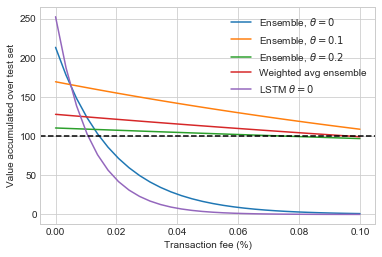

In [195]:
tc_axis = np.linspace(0, 0.1, 30)

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')
# plt.setp(ax.get_xticklabels(), rotation=30)
plt.xlabel("Transaction fee (%)")
plt.ylabel("Value accumulated over test set")
ax.plot(tc_axis, p_ens_180, label = "Ensemble, $\\theta = 0$")
ax.plot(tc_axis, p_ens_180_01, label = "Ensemble, $\\theta = 0.1$")
ax.plot(tc_axis, p_ens_180_02, label = "Ensemble, $\\theta = 0.2$")
ax.plot(tc_axis, p_ens058, label = "Weighted avg ensemble")
ax.plot(tc_axis, p_lstm_180, label = "LSTM $\\theta = 0$")
# ax.plot(tc_axis, p_lstm_180_02, label = "LSTM $\\theta = 0.2$")

# ax.plot(tc_axis, p_lstm_180_01, label = "lstm 180 01")
# ax.plot(tc_axis, p_ens_30_02, label = "ens 30 02")
ax.axhline(100, color = 'black', linestyle= 'dashed' )

ax.legend()

plt.savefig('img/Profit_under_tc.eps')  

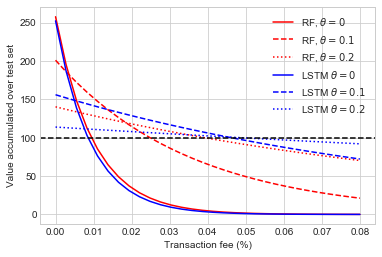

In [196]:
# p_lstm_180 = profit_vec(true_changes, lstm_180_0)
p_lstm_180_01 = profit_vec(true_changes, lstm_180_01)
# p_lstm_180_02 = profit_vec(true_changes, lstm_180_02)

p_rf_180 = profit_vec(true_changes, rf_180_0)
p_rf_180_01 = profit_vec(true_changes, rf_180_01)
p_rf_180_02 = profit_vec(true_changes, rf_180_02)

tc_axis = np.linspace(0, 0.08, 30)

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')
# plt.setp(ax.get_xticklabels(), rotation=30)
plt.xlabel("Transaction fee (%)")
plt.ylabel("Value accumulated over test set")
ax.plot(tc_axis, p_rf_180, label = "RF, $\\theta = 0$", color = 'red', linestyle = 'solid')
ax.plot(tc_axis, p_rf_180_01, label = "RF, $\\theta = 0.1$", color = 'red', linestyle = 'dashed')
ax.plot(tc_axis, p_rf_180_02, label = "RF, $\\theta = 0.2$", color = 'red', linestyle = 'dotted')
ax.plot(tc_axis, p_lstm_180, label = "LSTM $\\theta = 0$", color = 'blue', linestyle = 'solid')
ax.plot(tc_axis, p_lstm_180_01, label = "LSTM $\\theta = 0.1$", color = 'blue', linestyle = 'dashed')
ax.plot(tc_axis, p_lstm_180_02, label = "LSTM $\\theta = 0.2$", color = 'blue', linestyle = 'dotted')


# ax.plot(tc_axis, p_lstm_180_01, label = "lstm 180 01")
# ax.plot(tc_axis, p_ens_30_02, label = "ens 30 02")
ax.axhline(100, color = 'black', linestyle= 'dashed' )

ax.legend()

plt.savefig('img/Profit_under_tc_appendix.eps')  

## Cumulative profits, Maximum drawdown, daily returns.

In [161]:
import math
import scipy
change_test = y_test_sub["change"]

def calculate_cumprof(true_change, predictions, tc = 0):
    assert len(true_change) == len(predictions), "lengths of vectors don't match up"
    cur_r = 1
    cum_prof = [0] * len(predictions)
    for i, fc in enumerate(predictions):
        cur_r *= (1 + true_change[i]*fc/100 - tc*fc)
        cum_prof[i] = cur_r
    return cum_prof
        

def calculate_mdd(cum_prof, verbose = False):
    mdd = 0
    i_mdd = 0
    for i, cur_prof in enumerate(cum_prof):
        mdd_cur = (min(cum_prof[i:]) - cur_prof)/cur_prof
        if mdd_cur < mdd:   
            mdd = mdd_cur
            i_mdd = i
    if verbose:
        print(f"mdd:{mdd}, i:{i_mdd}, date:{y_test_sub.index[i_mdd]}")
    return mdd

def calculate_return_vector(true_change, predictions, tc = 0):

    assert len(true_change) == len(predictions), "lengths of vectors don't match up"
    returns = [0] * len(predictions)
    for i, fc in enumerate(predictions):
        returns[i] = (true_change[i]*fc/100 - tc*fc)
    return returns
# rf = 0.18
# rf_15 = math.exp((math.log(1 + rf/100)/35040)) - 1
# excess_returns = [x - rf_15 for x in non_cum_returns]

# requires data to be 15 min data.
def calculate_daily_returns(true_change, predictions, tc = 0):

    assert len(true_change) == len(predictions), "lengths of vectors don't match up"
    predictions = np.array(predictions)
    no_days = math.ceil(len(predictions)/96)
    daily_returns = [0] * no_days
    for j in range(0, no_days):
        r = 1
        for i in range(0,96):
            idx = i + 96 * j
            fc = predictions[idx]
            r = r * (1 + true_change[idx]*fc/100 - tc*fc)
            # print((1 + true_change[idx]*fc/100 - tc*fc))
        daily_returns[j] = r
    daily_returns = [(x-1)*100 for x in daily_returns]
    return daily_returns

def test_annualized_sharpe(daily_returns, baseline_returns):
    assert len(daily_returns) == len(baseline_returns), "lengths of vectors don't match up"
    daily_returns = np.array(daily_returns)
    baseline_returns = np.array(baseline_returns)

    sr = (np.mean(daily_returns) / np.std(daily_returns))*math.sqrt(365)
    sr_b = (np.mean(baseline_returns) / np.std(baseline_returns))*math.sqrt(365)

    sk = skew(daily_returns)
    kurt = kurtosis(daily_returns)
    sk_b = skew(baseline_returns)
    kurt_b = kurtosis(baseline_returns)
    var = (1-sk*sr+(kurt-1)/4*(sr**2)) / (len(daily_returns)-1)
    var_b = (1-sk_b*sr_b+(kurt_b-1)/4*(sr_b**2)) / (len(baseline_returns)-1)

    zscore = (sr - sr_b) / math.sqrt(var + var_b)
    signf = scipy.stats.norm.sf(zscore)
    return sr, signf, np.std(daily_returns)

def create_stats_table(true_change, predictions_list, names_list, baseline_pred):
    df = pd.DataFrame(columns=["Method", "Max. Drawdown", "Mean profit per trade", "Sharpe Ratio","Std. deviation (\%)"])
    for i, predic_vec in enumerate(predictions_list):
        # print(names_list[i])
        daily_return = calculate_daily_returns(true_change, predic_vec)
        baseline_return = calculate_daily_returns(true_change, baseline_pred)
        mdd = calculate_mdd(calculate_cumprof(true_change, predic_vec))
        mean_ret = np.round(np.sum(calculate_return_vector(true_change, predic_vec) / np.sum(predic_vec))*100, decimals=4)
        sr, signf, std = test_annualized_sharpe(daily_return, baseline_return)
        sr = np.round(sr, decimals=1)
        if signf < 0.01:
            sr_str = str(sr) + "***"
        elif signf < 0.05:
            sr_str = str(sr) + "**"
        elif signf < 0.1: 
            sr_str = str(sr) + "*"
        else:
            sr_str = str(sr)
        df = df.append({"Method":names_list[i], "Max. Drawdown":str(np.round(mdd*100))+'\%', "Mean profit per trade":str(mean_ret) + '\%', "Sharpe Ratio":sr_str, "Std. deviation (\%)": np.round(std, decimals=2)}, ignore_index=True)
    return df


In [151]:
# cumprof_180 = calculate_cumprof(change_test, ens_180_0)
# calculate_mdd(cumprof_180, True)
# print(create_stats_table(change_test, [ens_180_0, ens_180_01, ens_180_02, lstm_180_0, rf_fc_180_10_t0[17280:], naive_fc_0, bh_fc], ["Ensemble, $\theta = 0$","Ensemble, $\theta = 0.1$", "Ensemble, $\theta = 0.2$",  "LSTM, $\theta = 0$", "RF, $\theta = 0$",  "Naive forecast", "Buy and hold"], naive_fc_0).to_latex(index=False, escape = False))
print(create_stats_table(change_test, [ens_180_0, ens_180_01, ens_180_02, ens_p058, lstm_180_0, rf_180_0, naive_fc_0, bh_fc], ["Ensemble, $\theta = 0$","Ensemble, $\theta = 0.1$", "Ensemble, $\theta = 0.2$", "Weighted avg ensemble",  "LSTM, $\theta = 0$", "RF, $\theta = 0$",  "Naive forecast", "Buy and hold"], bh_fc).to_latex(index=False, escape = False))

\begin{tabular}{llllr}
\toprule
                   Method & Max. Drawdown & Mean profit per trade & Sharpe Ratio &  Std. deviation (\%) \\
\midrule
   Ensemble, $\theta = 0$ &        -9.0\% &              0.0148\% &       5.5*** &                 1.45 \\
 Ensemble, $\theta = 0.1$ &        -7.0\% &              0.1209\% &       7.5*** &                 0.73 \\
 Ensemble, $\theta = 0.2$ &        -8.0\% &               0.078\% &          2.5 &                 0.40 \\
    Weighted avg ensemble &       -10.0\% &              0.0994\% &          2.9 &                 0.88 \\
       LSTM, $\theta = 0$ &       -16.0\% &              0.0112\% &       5.3*** &                 1.87 \\
         RF, $\theta = 0$ &       -12.0\% &              0.0122\% &        5.4** &                 1.88 \\
           Naive forecast &       -22.0\% &              0.0054\% &          2.4 &                 2.10 \\
             Buy and hold &       -20.0\% &              0.0064\% &          4.2 &                 2.80

In [153]:
# APPENDIX

pred_app = [ens_180_0, ens_90_0, ens_30_0, ens_180_01, ens_90_01, ens_30_01, ens_180_02, ens_90_02, ens_30_02]
names_app = ["180 days, $\theta = 0$", "90 days, $\theta = 0$", "30 days, $\theta = 0$", "180 days, $\theta = 0.1$", "90 days, $\theta = 0.1$", "30 days, $\theta = 0.1$", "180 days, $\theta = 0.2$", "90 days, $\theta = 0.2$", "30 days, $\theta = 0.2$",]
print(create_stats_table(change_test, pred_app, names_app, bh_fc).to_latex(index=False, escape = False))

\begin{tabular}{llllr}
\toprule
                   Method & Max. Drawdown & Mean profit per trade & Sharpe Ratio &  Std. deviation (\%) \\
\midrule
   180 days, $\theta = 0$ &        -9.0\% &              0.0148\% &       5.5*** &                 1.45 \\
    90 days, $\theta = 0$ &       -11.0\% &              0.0154\% &       6.5*** &                 1.33 \\
    30 days, $\theta = 0$ &       -14.0\% &              0.0123\% &          4.3 &                 1.49 \\
 180 days, $\theta = 0.1$ &        -7.0\% &              0.1209\% &       7.5*** &                 0.73 \\
  90 days, $\theta = 0.1$ &        -8.0\% &              0.0552\% &          4.3 &                 0.76 \\
  30 days, $\theta = 0.1$ &        -9.0\% &               0.037\% &          2.5 &                 0.68 \\
 180 days, $\theta = 0.2$ &        -8.0\% &               0.078\% &          2.5 &                 0.40 \\
  90 days, $\theta = 0.2$ &        -8.0\% &              0.0925\% &          2.4 &                 0.72

In [570]:
(np.sum(returnff) / np.sum(ens_180_0)) * 100

0.017678280180088626

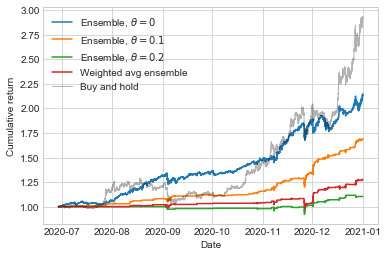

In [199]:


cum_prof_ens_0 = calculate_cumprof(change_test, ens_180_0)
cum_prof_ens_01 = calculate_cumprof(change_test, ens_180_01)
cum_prof_lstm = calculate_cumprof(change_test, lstm_180_0)
cum_prof_ens_02 = calculate_cumprof(change_test, ens_180_02)
cum_prof_ens_p058 = calculate_cumprof(change_test, ens_p058)
cum_prof_bh = calculate_cumprof(change_test, bh_fc)

fig, ax = plt.subplots()
plt.setp(ax.get_xticklabels(), rotation=0)
plt.xlabel("Date")
plt.ylabel("Cumulative return")
ax.plot(y_test_sub.index, cum_prof_ens_0, label = "Ensemble, $\\theta = 0$")
ax.plot(y_test_sub.index, cum_prof_ens_01, label = "Ensemble, $\\theta = 0.1$")
ax.plot(y_test_sub.index, cum_prof_ens_02, label = "Ensemble, $\\theta = 0.2$")
ax.plot(y_test_sub.index, cum_prof_ens_p058, label = "Weighted avg ensemble")
ax.plot(y_test_sub.index, cum_prof_bh, label = "Buy and hold", alpha = 0.3, color = "black", lw = 1)
# ax.plot(y_test_sub.index, cum_prof_lstm, label = "LSTM, $\\theta = 0$")
ax.legend()
plt.savefig('img/cum_returns.png', dpi=300)  

Maximum drawdown:|

In [200]:
rf_fi = RandomForestClassifier(n_estimators=100, random_state=280183, n_jobs=-1)
rf_fi.fit(X_test, y_test["y_2"])
importances = rf_fi.feature_importances_
std_fi = np.std([tree.feature_importances_ for tree in rf_fi.estimators_], axis=0)
X_test

,open,high,low,close,volume,RSI_14,STOCHk_14_3_3,STOCHd_14_3_3,WILLR_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,OBV,SMA_10,diff_no_leak,gold_close,gold_volume
date,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,6399.5,6400.5,6388.4,6393.9,16.285230,50.698972,62.871839,65.447120,-44.230769,0.917063,2.949972,-2.032908,102992.413244,6396.29,-3.5,0.0,0.0
2020-01-01 00:15:00,6393.9,6396.5,6383.2,6391.1,10.591921,49.166030,56.289195,60.819761,-51.084337,0.673613,2.165217,-1.491604,102981.821323,6396.63,-2.8,0.0,0.0
2020-01-01 00:30:00,6391.6,6395.5,6391.4,6394.2,1.044093,50.934867,52.678470,57.279835,-46.649485,0.722492,1.771277,-1.048785,102982.865416,6397.26,3.1,0.0,0.0
2020-01-01 00:45:00,6394.2,6404.0,6394.1,6403.5,126.973423,55.893300,58.919644,55.962436,-25.507246,1.494434,2.034575,-0.540141,103109.838839,6398.31,9.3,0.0,0.0
2020-01-01 01:00:00,6403.4,6416.2,6400.8,6416.2,7.410877,61.600264,75.947756,62.515290,0.000000,3.095307,2.908359,0.186948,103117.249716,6400.33,12.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:45:00,23834.6,23850.0,23790.3,23814.7,35.611130,60.774033,81.681698,76.618818,-19.824945,88.757444,4.388718,84.368726,123299.855009,23778.68,-19.3,0.0,0.0
2020-12-31 23:00:00,23814.8,23827.1,23701.0,23790.0,48.415412,58.778165,79.833957,80.223489,-30.634573,85.256263,0.710030,84.546233,123251.439598,23787.68,-24.7,0.0,0.0
2020-12-31 23:15:00,23790.1,23832.1,23713.9,23714.0,86.977445,53.009578,61.881838,74.465831,-63.894967,75.478914,-7.253855,82.732769,123164.462152,23777.09,-76.0,0.0,0.0


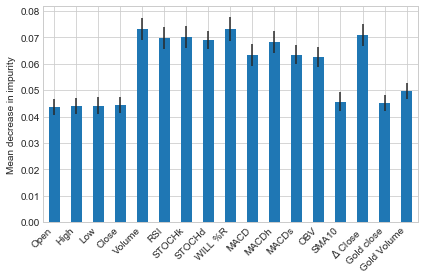

In [201]:
fi = pd.Series(importances, index=X_train.columns.values)
labels = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'STOCHk', 'STOCHd', 'WILL %R', "MACD", "MACDh", "MACDs", "OBV", "SMA10", "$\Delta$ Close", "Gold close", "Gold Volume"]
fig, ax = plt.subplots()

fi.plot.bar(yerr=std_fi, ax=ax)

ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(labels, rotation=45, ha='right')
fig.tight_layout()
plt.savefig('img/feature_importances.eps')  

In [202]:
X_train_val

,open,high,low,close,volume,RSI_14,STOCHk_14_3_3,STOCHd_14_3_3,WILLR_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,OBV,SMA_10,diff_no_leak,gold_close,gold_volume
date,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,3235.9,3238.5,3229.3,3237.1,36.931860,42.983171,85.139319,84.447151,-10.526316,-12.369672,4.454926,-16.824599,96160.545480,3228.92,1.2,0.0,0.0
2019-01-01 00:15:00,3236.2,3237.1,3228.6,3231.8,8.578142,40.050417,82.765738,83.957703,-26.934985,-11.619174,4.164339,-15.783514,96151.967338,3230.34,-5.3,0.0,0.0
2019-01-01 00:30:00,3232.0,3243.1,3232.0,3241.4,20.204627,47.092118,85.889213,84.598090,-4.871060,-10.132953,4.520449,-14.653402,96172.171965,3233.62,9.6,0.0,0.0
2019-01-01 00:45:00,3241.0,3250.0,3237.3,3239.7,27.394098,46.060352,81.184269,83.279740,-24.641148,-8.988672,4.531784,-13.520456,96144.777867,3235.69,-1.7,0.0,0.0
2019-01-01 01:00:00,3239.5,3241.4,3230.5,3237.7,22.552554,44.816311,80.353985,82.475822,-29.425837,-8.149265,4.296953,-12.446218,96122.225314,3236.58,-2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 22:45:00,6397.9,6411.5,6397.0,6410.1,32.060778,59.923197,93.544123,92.623046,-3.139013,-1.652279,5.741058,-7.393336,103027.984335,6386.33,14.1,0.0,0.0
2019-12-31 23:00:00,6410.2,6412.3,6401.6,6405.4,7.786040,57.197831,90.433351,91.583189,-15.198238,-0.173242,5.776075,-5.949317,103020.198295,6388.95,-4.7,0.0,0.0
2019-12-31 23:15:00,6406.1,6406.1,6392.6,6392.8,7.066371,50.559080,79.570402,87.849292,-42.951542,-0.017607,4.745368,-4.762975,103013.131924,6391.14,-12.6,0.0,0.0


# Misc

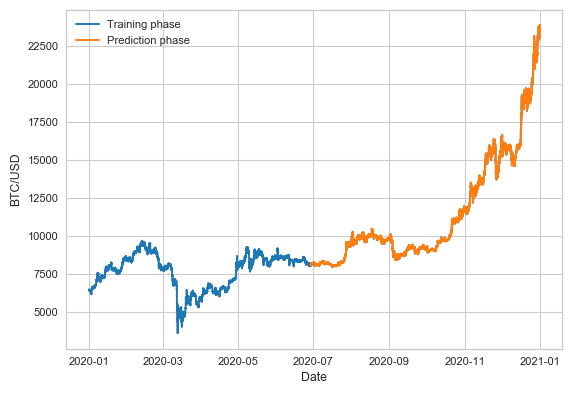

In [523]:
fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')
plt.setp(ax.get_xticklabels(), rotation=0)
plt.xlabel("Date")
plt.ylabel("BTC/USD")

ax.plot(X_test.index, X_test["close"], label = "Training phase")
ax.plot(X_test.index[17280:], X_test["close"][17280:], label="Prediction phase")

ax.legend()
plt.savefig('img/bitcoin_val_test_set.eps')  
# ax.plot(X_test.index, X_test["close"])

In [43]:
X_loss = X_train_val[300:18540]
Y_loss = y_val[300:18540]
X_loss

# pred_b, pred_r, model = forecast_LSTM2(X_loss, Y_loss.iloc[:,3], 180, 10, time_step = 96, epochs = 100)

,open,high,low,close,volume,RSI_14,STOCHk_14_3_3,STOCHd_14_3_3,WILLR_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,OBV,SMA_10,diff_no_leak,gold_close,gold_volume
date,,,,,,,,,,,,,,,,,
2019-01-04 03:00:00,3322.1,3323.7,3321.5,3321.8,11.346811,44.971157,67.316173,61.973057,-34.534535,-3.797385,0.884353,-4.681738,97044.917195,3321.80,-1.1,1295.755,0.58747
2019-01-04 03:15:00,3321.8,3323.6,3320.3,3323.1,4.330210,46.328030,67.867868,65.917852,-30.630631,-3.493309,0.950743,-4.444052,97049.247405,3322.60,1.3,1295.425,0.38770
2019-01-04 03:30:00,3324.4,3325.0,3323.4,3325.0,20.167806,48.333217,70.953914,68.712652,-21.973094,-3.063697,1.104284,-4.167981,97069.415211,3323.08,1.9,1295.048,0.38844
2019-01-04 03:45:00,3325.0,3344.4,3324.9,3338.8,60.314827,60.017199,77.392961,72.071581,-15.217391,-1.591338,2.061315,-3.652653,97129.730038,3324.75,13.8,1295.495,0.32766
2019-01-04 04:00:00,3340.2,3349.2,3321.3,3332.6,149.345364,54.098062,74.269838,74.205571,-40.000000,-0.914232,2.190737,-3.104968,96980.384674,3325.29,-6.2,1294.975,0.42884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-13 01:45:00,10427.8,10445.0,10392.2,10404.9,15.674966,45.340215,28.767908,20.510703,-71.805158,4.192843,-15.834007,20.026850,124849.877072,10445.76,-16.6,0.000,0.00000
2019-07-13 02:00:00,10404.3,10441.7,10404.3,10435.4,27.101443,50.313311,37.191977,28.938806,-54.326648,3.625864,-13.120789,16.746653,124876.978515,10441.42,30.5,0.000,0.00000
2019-07-13 02:15:00,10435.4,10441.6,10406.9,10434.5,13.343713,50.168262,39.675263,35.211716,-54.842407,3.068535,-10.942495,14.011029,124863.634802,10436.39,-0.9,0.000,0.00000


In [44]:
pred_b2, pred_r2, history = forecast_LSTM2(X_loss, Y_loss.iloc[:,3], 180, 10, time_step = 96, epochs = 40)
pred_b2, pred_r2, history01 = forecast_LSTM2(X_loss, Y_loss.iloc[:,4], 180, 10, time_step = 96, epochs = 40)
pred_b2, pred_r2, history02 = forecast_LSTM2(X_loss, Y_loss.iloc[:,5], 180, 10, time_step = 96, epochs = 40)



starting now
              precision    recall  f1-score   support

           0     0.5216    0.6054    0.5604       479
           1     0.5322    0.4470    0.4859       481

    accuracy                         0.5260       960
   macro avg     0.5269    0.5262    0.5231       960
weighted avg     0.5269    0.5260    0.5231       960

Training currently starting at: 2019-01-14 03:00:00
starting now
              precision    recall  f1-score   support

           0     0.6224    0.5734    0.5969       572
           1     0.4365    0.4871    0.4604       388

    accuracy                         0.5385       960
   macro avg     0.5294    0.5303    0.5287       960
weighted avg     0.5473    0.5385    0.5417       960

Training currently starting at: 2019-01-14 03:00:00
starting now
              precision    recall  f1-score   support

           0     0.7092    0.8167    0.7592       660
           1     0.3950    0.2633    0.3160       300

    accuracy                         0.

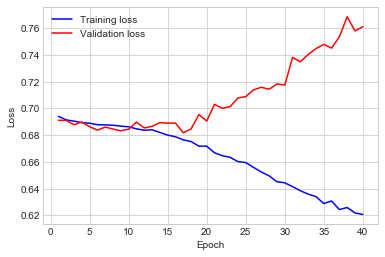

In [186]:

# plt.plot(epochs, loss, 'b', label="training loss")
# plt.plot(epochs, val_loss, 'r', label="validation loss")
# plt.title("(Validation) Loss versus Epochs")
# plt.legend()
# plt.figure()
# plt.savefig('img/loss_val_loss0.eps')  

loss = history.history['loss']
val_loss = history.history['val_loss']
fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')
plt.xlabel("Epoch")
plt.ylabel("Loss")
ax.plot(range(1, len(loss)+1), loss, 'b', label = "Training loss")
ax.plot(range(1, len(loss)+1), val_loss, 'r', label="Validation loss")
ax.legend()
plt.savefig('img/loss_val_loss0.eps')  


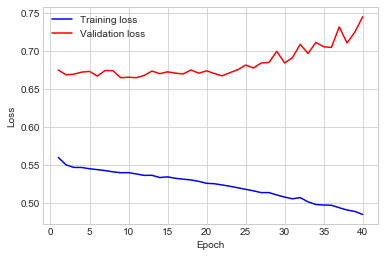

In [187]:

loss = history01.history['loss']
val_loss = history01.history['val_loss']
fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')
plt.xlabel("Epoch")
plt.ylabel("Loss")
ax.plot(range(1, len(loss)+1), loss, 'b', label = "Training loss")
ax.plot(range(1, len(loss)+1), val_loss, 'r', label="Validation loss")
ax.legend()
plt.savefig('img/loss_val_loss01.eps')  


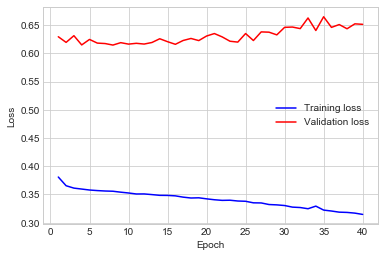

In [188]:

loss = history02.history['loss']
val_loss = history02.history['val_loss']
fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')
plt.xlabel("Epoch")
plt.ylabel("Loss")
ax.plot(range(1, len(loss)+1), loss, 'b', label = "Training loss")
ax.plot(range(1, len(loss)+1), val_loss, 'r', label="Validation loss")
ax.legend()
plt.savefig('img/loss_val_loss02.eps')  


In [107]:
val_loss

[0.6933098435401917,
 0.6929845809936523,
 0.692608654499054,
 0.6921480894088745,
 0.6926006078720093,
 0.6902762055397034,
 0.6871022582054138,
 0.6862636208534241,
 0.6878688335418701,
 0.6872482895851135,
 0.6887316107749939,
 0.6914041638374329,
 0.6930174231529236,
 0.6894538998603821,
 0.694290041923523,
 0.6946551203727722,
 0.6945762634277344,
 0.7042363286018372,
 0.6986016631126404,
 0.7022463083267212,
 0.7262833118438721,
 0.7098769545555115,
 0.7083771228790283,
 0.7108142375946045,
 0.7204447388648987,
 0.7260161638259888,
 0.7305960059165955,
 0.7405039072036743,
 0.7361583113670349,
 0.7472615838050842,
 0.7459564805030823,
 0.7499774098396301,
 0.7559797167778015,
 0.7662532925605774,
 0.7730122804641724,
 0.7605659365653992,
 0.8015660643577576,
 0.7840271592140198,
 0.8066278100013733,
 0.7879558801651001,
 0.8530062437057495,
 0.8075109124183655,
 0.8209469318389893,
 0.8537067174911499,
 0.8241564631462097,
 0.8408569693565369,
 0.8399194478988647,
 0.861155569553

In [114]:
pred_val_10, pred_val_r_10, model10 = forecast_LSTM2(X_train_val, y_val.iloc[:,3], 180, 10, time_step = 96, epochs = 10)
# pred_val_50, pred_val_r_50, model50 = forecast_LSTM2(X_train_val, y_val.iloc[:,3], 180, 10, time_step = 96, epochs = 50)
# pred_val_100, pred_val_r_100, model100 = forecast_LSTM2(X_train_val, y_val.iloc[:,3], 180, 10, time_step = 96, epochs = 100)
# pred_val_150, pred_val_r_150, model150 = forecast_LSTM2(X_train_val, y_val.iloc[:,3], 180, 10, time_step = 96, epochs = 150)
# pred_val_200, pred_val_r_200, model200 = forecast_LSTM2(X_train_val, y_val.iloc[:,3], 180, 10, time_step = 96, epochs = 200)

# np.savetxt("y_train_180_b_75.csv", np.array(pred_val_1), fmt="%10s")
# np.savetxt("y_train_180_p_75.csv", np.array(pred_val_r_1), fmt="%10s")
# np.savetxt("y_tr ain_180_b_50.csv", np.array(pred_val_50), fmt="%10s")
# np.savetxt("y_train_180_r_50.csv", np.array(pred_val_r_50), fmt="%10s")
# np.savetxt("y_train_180_b_100.csv", np.array(pred_val_100), fmt="%10s")
# np.savetxt("y_train_180_r_100.csv", np.array(pred_val_r_100), fmt="%10s")
# np.savetxt("y_train_180_b_150.csv", np.array(pred_val_150), fmt="%10s")
# np.savetxt("y_train_180_r_150.csv", np.array(pred_val_r_150), fmt="%10s")
# np.savetxt("y_train_180_b_200.csv", np.array(pred_val_200), fmt="%10s")
# np.savetxt("y_train_180_r_200.csv", np.array(pred_val_r_200), fmt="%10s")


starting now
              precision    recall  f1-score   support

           0     0.5409    0.6466    0.5890       481
           1     0.5584    0.4489    0.4977       479

    accuracy                         0.5479       960
   macro avg     0.5497    0.5477    0.5434       960
weighted avg     0.5496    0.5479    0.5434       960

Training currently starting at: 2019-01-11 00:00:00
              precision    recall  f1-score   support

           0     0.5827    0.4361    0.4989       509
           1     0.5043    0.6475    0.5670       451

    accuracy                         0.5354       960
   macro avg     0.5435    0.5418    0.5329       960
weighted avg     0.5459    0.5354    0.5309       960

Training currently starting at: 2019-01-21 00:00:00
              precision    recall  f1-score   support

           0     0.4958    0.7511    0.5973       470
           1     0.5282    0.2673    0.3550       490

    accuracy                         0.5042       960
   macro av

In [117]:
lstm_train_75 = pd.read_csv("y_train_180_b_75.csv", header = None)[17280:].iloc[:,0].astype(int)
lstm_train_15 = pd.read_csv("y_train_180_b_15.csv", header = None)[17280:].iloc[:,0].astype(int)
y_sub_c = y_val.iloc[:,3][17280:]
y_chance_train = y_val['change'][17280:]
print(classification_report(y_sub_c, lstm_train_15))
print(classification_report(y_sub_c, pred_val_10[17280:]))


              precision    recall  f1-score   support

           0       0.54      0.56      0.55      9023
           1       0.53      0.51      0.52      8737

    accuracy                           0.54     17760
   macro avg       0.54      0.54      0.54     17760
weighted avg       0.54      0.54      0.54     17760

              precision    recall  f1-score   support

           0       0.54      0.57      0.56      9023
           1       0.53      0.49      0.51      8737

    accuracy                           0.53     17760
   macro avg       0.53      0.53      0.53     17760
weighted avg       0.53      0.53      0.53     17760



In [81]:
create_profit_table(y_chance_train, [lstm_train_15, pred_val_50[17280:], pred_val_100[17280:], pred_val_150[17280:]], ['lstm15', 'lstm50', 'lstm100', 'lstm150']) 

,Method,tc=0,tc=0.01\%,tc=0.05\%
0,lstm15,96.541772,41.855497,1.477537
1,lstm50,123.996629,51.250461,1.494395
2,lstm100,105.625427,43.278353,1.218687
3,lstm150,110.414264,44.768126,1.208792


In [ ]:
pred_b2, pred_r2, model2 = forecast_LSTM2(X_loss, Y_loss.iloc[:,3], 180, 10, time_step = 96, epochs = 200)

In [34]:
X_test

,open,high,low,close,volume,RSI_14,STOCHk_14_3_3,STOCHd_14_3_3,WILLR_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,OBV,SMA_10,diff_no_leak
date,,,,,,,,,,,,,,,
2020-01-01 00:00:00,6399.5,6400.5,6388.4,6393.9,16.285230,50.698972,62.871839,65.447120,-44.230769,0.917063,2.949972,-2.032908,102992.413244,6396.29,-3.5
2020-01-01 00:15:00,6393.9,6396.5,6383.2,6391.1,10.591921,49.166030,56.289195,60.819761,-51.084337,0.673613,2.165217,-1.491604,102981.821323,6396.63,-2.8
2020-01-01 00:30:00,6391.6,6395.5,6391.4,6394.2,1.044093,50.934867,52.678470,57.279835,-46.649485,0.722492,1.771277,-1.048785,102982.865416,6397.26,3.1
2020-01-01 00:45:00,6394.2,6404.0,6394.1,6403.5,126.973423,55.893300,58.919644,55.962436,-25.507246,1.494434,2.034575,-0.540141,103109.838839,6398.31,9.3
2020-01-01 01:00:00,6403.4,6416.2,6400.8,6416.2,7.410877,61.600264,75.947756,62.515290,0.000000,3.095307,2.908359,0.186948,103117.249716,6400.33,12.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:45:00,23834.6,23850.0,23790.3,23814.7,35.611130,60.774033,81.681698,76.618818,-19.824945,88.757444,4.388718,84.368726,123299.855009,23778.68,-19.3
2020-12-31 23:00:00,23814.8,23827.1,23701.0,23790.0,48.415412,58.778165,79.833957,80.223489,-30.634573,85.256263,0.710030,84.546233,123251.439598,23787.68,-24.7
2020-12-31 23:15:00,23790.1,23832.1,23713.9,23714.0,86.977445,53.009578,61.881838,74.465831,-63.894967,75.478914,-7.253855,82.732769,123164.462152,23777.09,-76.0


In [42]:
def forecast_LSTM2(X, y, trainDays, testDays, time_step = 96, hunits = 36, epochs = 100):
    print("starting now")
    iter = 0
    startTrainDay = X.index[0]
    endTrainDay = startTrainDay + timedelta(days=trainDays)
    lastDate =  X.iloc[-1].name
    y_fc_final_b = []
    y_fc_final_raw = []
    # assert lastDate > endTestDay, "first testDay is already out of bounds"    
    
    while (endTrainDay < lastDate):
        # Data frames for training and testing sets.
        maskTrain = (X.index >= pd.to_datetime(startTrainDay)) & (X.index < pd.to_datetime(endTrainDay))
        Xtrain = X[maskTrain]
        if (iter == 0):
            y_fc_final_b += ["NaN"] * len(Xtrain)
            y_fc_final_raw += [-1] * len(Xtrain)
        Xtest = X.iloc[len(Xtrain)+iter*24*4*testDays-time_step+1:len(Xtrain)+24*4*testDays*(1+iter)]
        ytrain = y[maskTrain]
        ytrain = ytrain.iloc[time_step-1:,]
        ytest = y.iloc[len(Xtrain)+iter*24*4*testDays:len(Xtrain)+24*4*testDays*(1+iter)]

        stc = StandardScaler()
        training_set_scaled = stc.fit_transform(Xtrain.values)
        test_set_scaled = stc.transform(Xtest.values)

        X_train_3d = []
        for i in range(time_step, len(Xtrain)+1):
            X_train_3d.append(training_set_scaled[i-time_step:i, :])
        X_train_3d = np.array(X_train_3d)

        X_test_3d = []
        for i in range(time_step, len(Xtest)+1):
            X_test_3d.append(test_set_scaled[i-time_step:i, :])
        X_test_3d = np.array(X_test_3d)

        y_fc_binary, y_fc_raw, classifier = apply_lstm2(X_train_3d, ytrain, X_test_3d, ytest, hunits, epochs)
        y_fc_final_b += y_fc_binary 
        y_fc_final_raw += y_fc_raw
        iter+=1    
        startTrainDay = startTrainDay + timedelta(days=testDays)
        print(f"Training currently starting at: {startTrainDay}")
        endTrainDay = endTrainDay + timedelta(days=testDays)
        # print(f"start train: {Xtrain.index[0]}, start end: {Xtrain.index[-1]}, test_init: {Xtest.index[0]}, test_start:{ytest.index[0]}, test_end:{ytest.index[-1]}")
        # print(f"train_shape: {Xtrain.shape}, train_shape_3d: {X_train_3d.shape}, test_shape: {Xtest.shape}, X_test_3d_shape:{X_test_3d.shape}")
    # print(f"ytest_shape: {ytrain.index}, \n Test: {Xtrain.index}")
    return y_fc_final_b, y_fc_final_raw, classifier

def apply_lstm2(Xtrain, Ytrain, Xtest, Ytest, hunits, epochs_inp):
    # print(Ytest)
    classifier = Sequential()
    classifier.add(LSTM(units = hunits, return_sequences = True, input_shape = (Xtrain.shape[1], Xtrain.shape[2])))
    classifier.add(Dropout(0.2))
    classifier.add(LSTM(units = hunits))
    classifier.add(Dense(units = 1, activation ='sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [tf.keras.metrics.BinaryAccuracy()])
    history = classifier.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest), epochs = epochs_inp, batch_size = 48, verbose = 0)

    
    predicted_movement = classifier.predict(Xtest)
    # print(f"predicted movement:{predicted_movement[0:30]}")
    
    predicted_movement_binary = []
    for pred in predicted_movement:
        if pred > 0.5:
            predicted_movement_binary.append(1)
        elif pred <= 0.5: 
            predicted_movement_binary.append(0)
    predicted_movement_binary
    predicted_movement = np.array(predicted_movement).flatten().tolist()
    # print(f"predicted movement:{predicted_movement[0:5]}")
    # print(f"predicted movement binary:{predicted_movement_binary}")
    print(classification_report(Ytest,predicted_movement_binary, digits = 4))

    return predicted_movement_binary, predicted_movement, history
